<a href="https://colab.research.google.com/github/FidhaNawal/Needle-s-eye/blob/main/trial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install optuna
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install mediapipe
!pip install opencv-python
!pip install --upgrade numpy


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

In [4]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna()  # Handle missing values by dropping rows with NaNs
    return df


In [5]:
data = load_data('/content/drive/MyDrive/project/hand_landmarks_data.csv')

In [6]:
data.head(5)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [7]:
# Preprocess Data
def preprocess_data(df):

    X = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values

    # Normalize (x, y) using wrist as origin and scaling by mid-finger tip
    wrist_index = 0
    mid_finger_tip_index = 12

    for i in range(0, X.shape[1], 3):
        X[:, i] -= X[:, wrist_index]
        X[:, i+1] -= X[:, wrist_index+1]
        scale = np.linalg.norm(X[:, mid_finger_tip_index:mid_finger_tip_index+2], axis=1, keepdims=True)
        X[:, i:i+2] /= (scale + 1e-6)

    return X, y

In [8]:
X, y = preprocess_data(data)

In [9]:
print(X.shape, y.shape)

(25675, 63) (25675,)


In [10]:
# Visualize Data Distribution
def visualize_data_distribution(y):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title("Distribution of Gesture Classes")
    plt.xlabel("Gesture Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

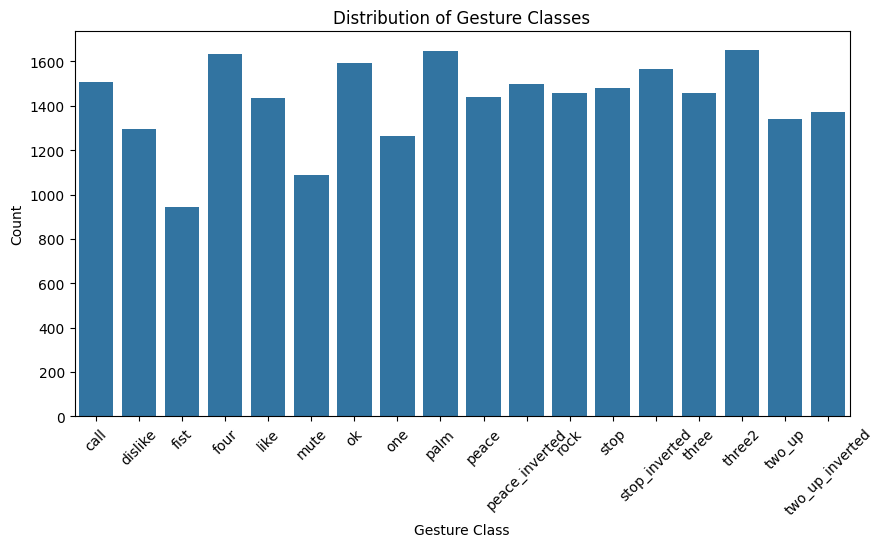

In [11]:
visualize_data_distribution(y)

In [12]:
# for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'y' is your categorical labels
print(y_encoded)

[ 0  0  0 ... 17 17 17]


In [13]:
# Split Data
def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_data(X, y)

In [15]:
# Train Models
def train_models(X_train, y_train, X_val, y_val):
    models = {
      "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
      "SVM": SVC(kernel='linear', probability=True),
      "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1,random_state=42)
    }

    trained_models = {}
    for name, model in models.items():
      if name == "XGBoost":
        X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_data(X, y_encoded)
        model.fit(X_train, y_train)
        val_accuracy = accuracy_score(y_val, model.predict(X_val))
        print(f"{name} Validation Accuracy: {val_accuracy:.4f}")
        trained_models[name] = model
      else:
        model.fit(X_train, y_train)
        val_accuracy = accuracy_score(y_val, model.predict(X_val))
        print(f"{name} Validation Accuracy: {val_accuracy:.4f}")
        trained_models[name] = model

    return trained_models

In [17]:
models = train_models(X_train, y_train, X_val, y_val)

Random Forest Validation Accuracy: 0.8430
SVM Validation Accuracy: 0.9147
XGBoost Validation Accuracy: 0.9190


In [18]:
# Evaluate Models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        if name == "XGBoost":
          X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_data(X, y_encoded)
          y_pred = model.predict(X_test)
          accuracy = accuracy_score(y_test, y_pred)
          precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
          recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
          f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
        else:
          y_pred = model.predict(X_test)
          accuracy = accuracy_score(y_test, y_pred)
          precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
          recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
          f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

        print(f"{name} Performance on Test Set:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("\n")

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(models, X_test, y_test):
    for name, model in models.items():
        if name == "XGBoost":
            X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_data(X, y_encoded)
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


In [20]:
evaluate_models(models, X_test, y_test)

Random Forest Performance on Test Set:
Accuracy: 0.8290
Precision: 0.8294
Recall: 0.8290
F1-score: 0.8284


SVM Performance on Test Set:
Accuracy: 0.9128
Precision: 0.9138
Recall: 0.9128
F1-score: 0.9125


XGBoost Performance on Test Set:
Accuracy: 0.9089
Precision: 0.9102
Recall: 0.9089
F1-score: 0.9091




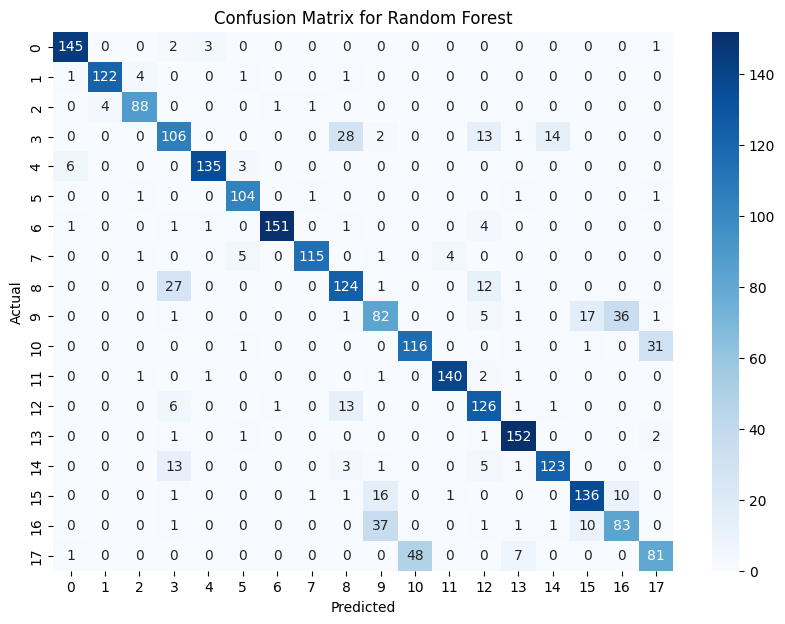

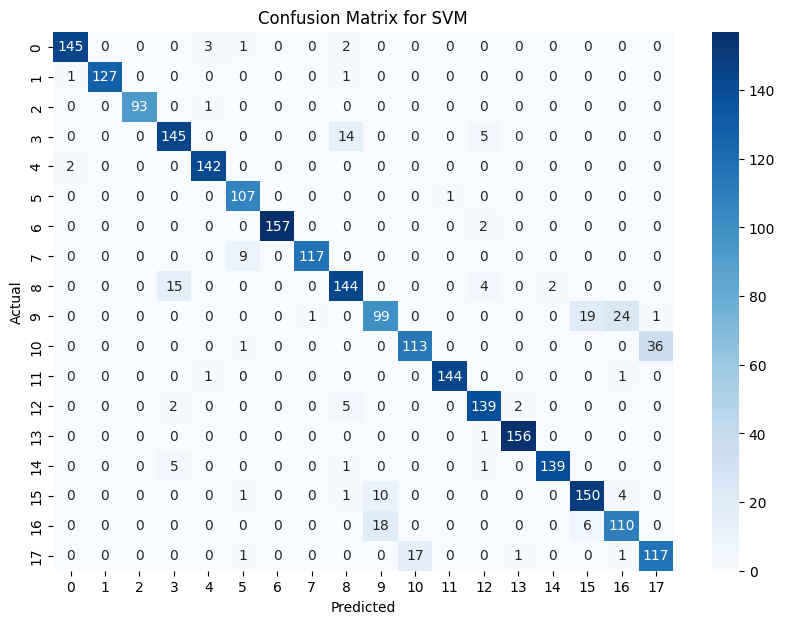

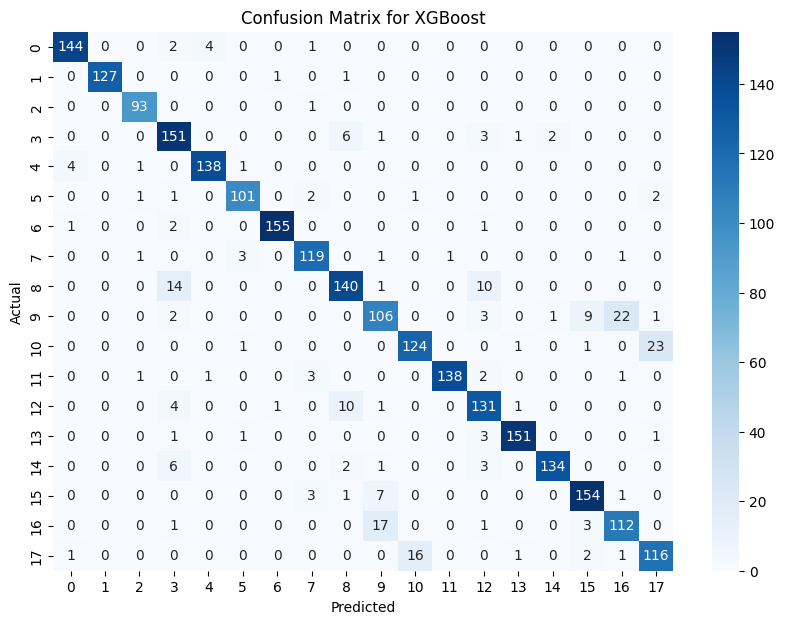

In [21]:
plot_confusion_matrix(models, X_test, y_test)

In [34]:
def process_video(video_path, model, scaler,model_name):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # Replace with Output actual path
    out = cv2.VideoWriter(f'/content/drive/MyDrive/Colab Notebooks/output5_video.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing = mp.solutions.drawing_utils
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                )

                # Draw landmark labels
                h, w, _ = frame.shape
                for idx, lm in enumerate(hand_landmarks.landmark):
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.putText(frame, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

                # Extract features and predict gesture
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten().reshape(1, -1)
                landmarks = scaler.transform(landmarks)
                if model_name == "XGBoost":
                  prediction = model.predict(landmarks)
                  prediction = label_encoder.inverse_transform(prediction)
                else:
                  prediction = model.predict(landmarks)

                # Display predicted gesture
                cv2.putText(frame, f"Gesture: {prediction[0]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame)  # Save frame to video file

    cap.release()
    out.release()


In [35]:
video_path = "/content/drive/MyDrive/in5.mp4"  # Replace with Input actual path

In [36]:

# Select the best-performing model

best_model = max(models, key=lambda name: accuracy_score(y_test, models[name].predict(X_test)))
print(f"Best performing model: {best_model}")

process_video(video_path, models[best_model], scaler, best_model)

Best performing model: SVM


In [26]:
# Visualizing the different classes
def plot_hand_gesture(df, sample_index):

    sample = df.iloc[sample_index]
    x_coords = [sample[f'x{i}'] for i in range(1, 22)]
    y_coords = [sample[f'y{i}'] for i in range(1, 22)]
    y_coords = np.max(y_coords) - np.array(y_coords)

    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),
        (0, 5), (5, 6), (6, 7), (7, 8),
        (5, 9), (9, 10), (10, 11), (11, 12),
        (9, 13), (13, 14), (14, 15), (15, 16),
        (0, 17), (13, 17), (17, 18), (18, 19), (19, 20)  # Pinky finger
    ]

    plt.figure(figsize=(5, 5))
    plt.scatter(x_coords, y_coords, color='red', label="Keypoints")
    for connection in connections:
        x1, y1 = x_coords[connection[0]], y_coords[connection[0]]
        x2, y2 = x_coords[connection[1]], y_coords[connection[1]]
        plt.plot([x1, x2], [y1, y2], 'b', linewidth=2)

    gesture_label = sample['label']

    # Display plot
    plt.title(f"Hand Gesture: {gesture_label}")
    plt.axis("equal")
    plt.legend()
    plt.show()

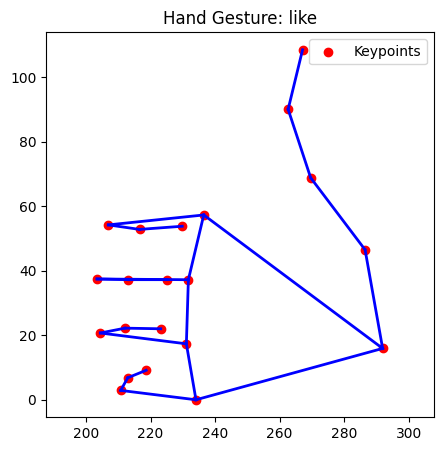

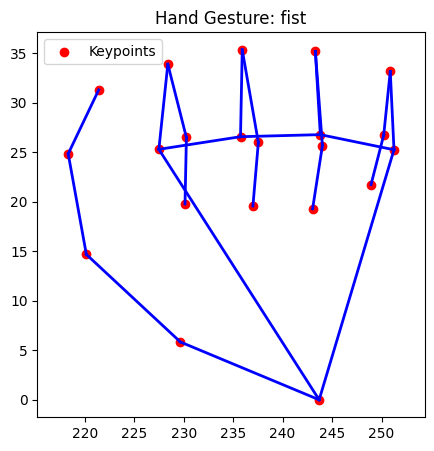

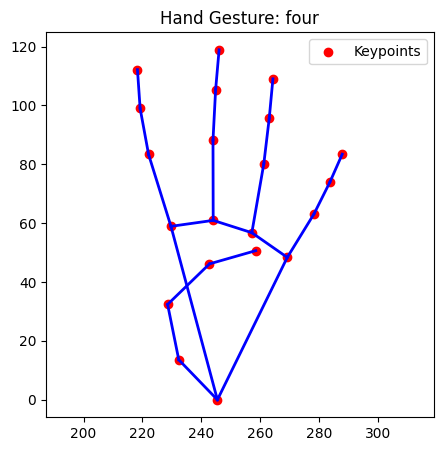

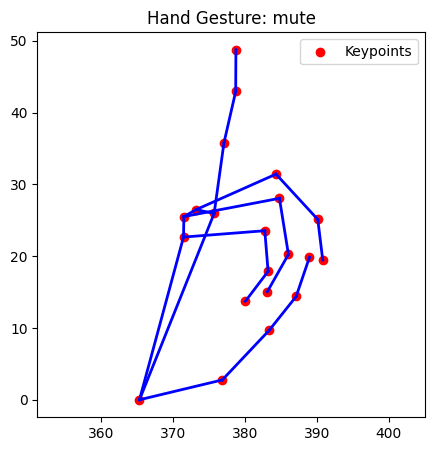

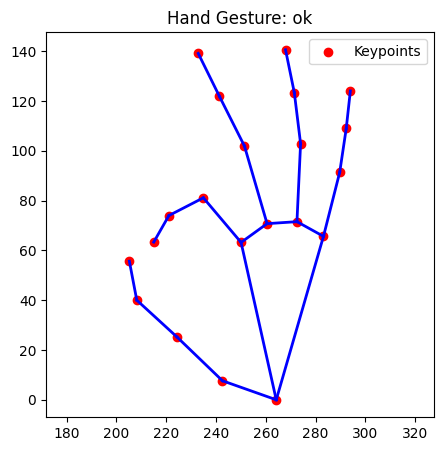

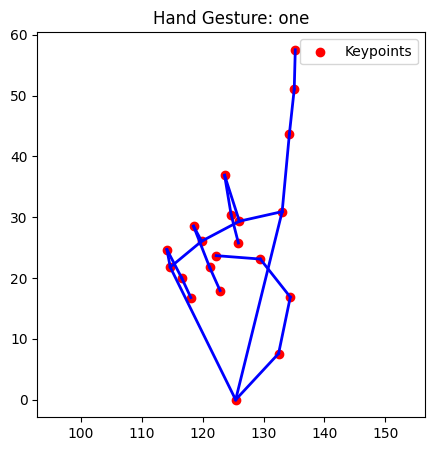

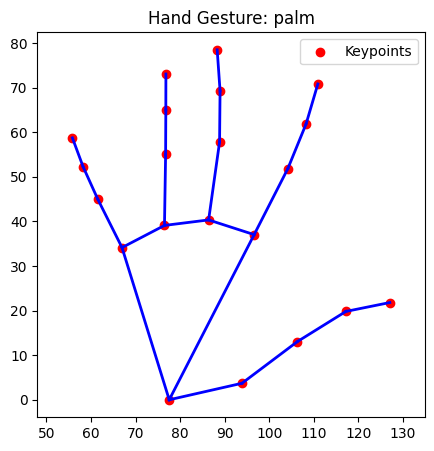

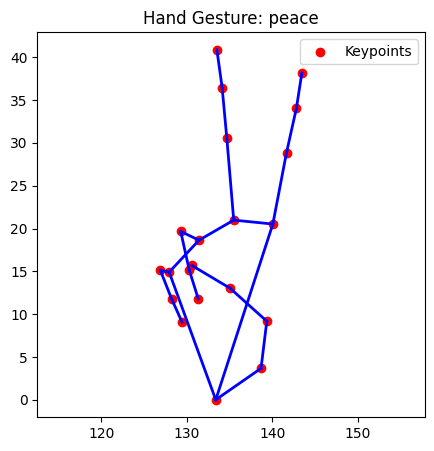

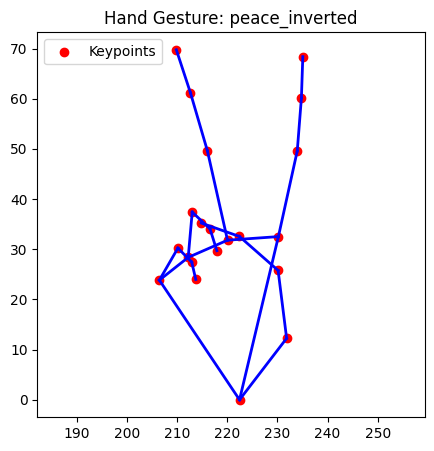

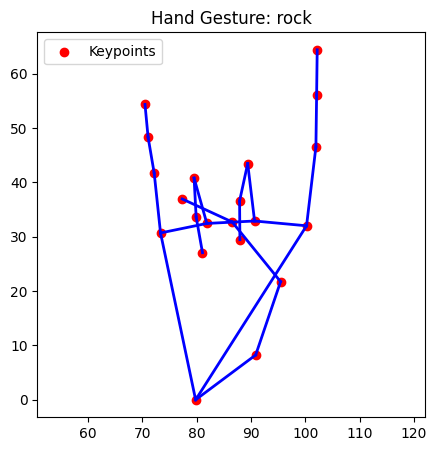

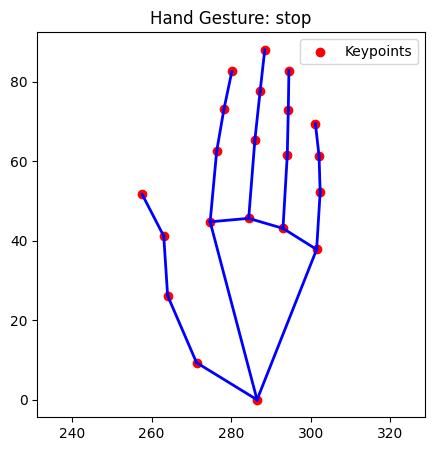

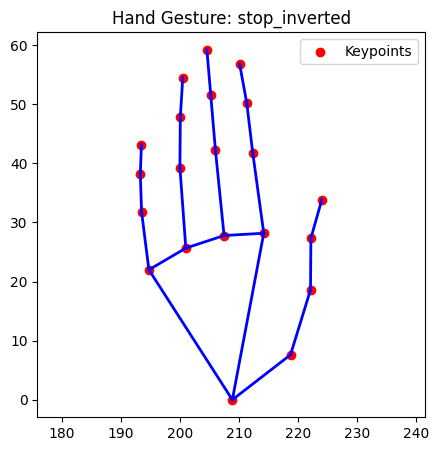

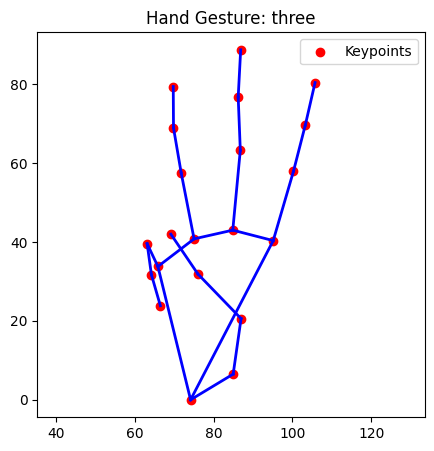

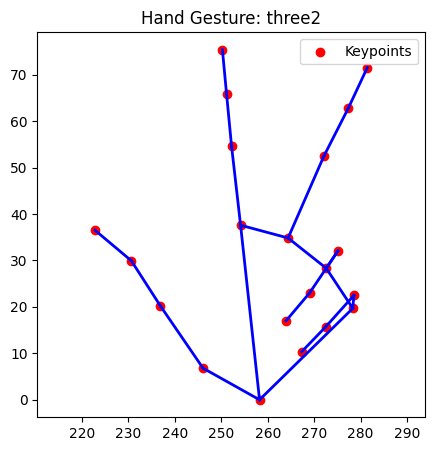

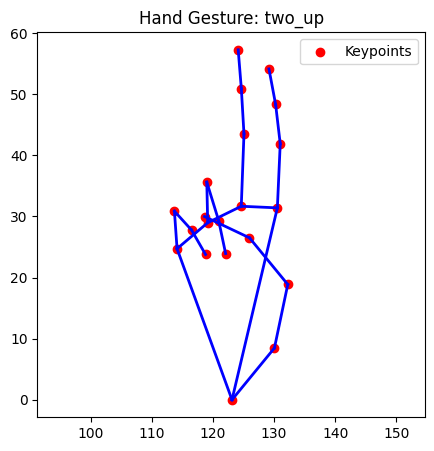

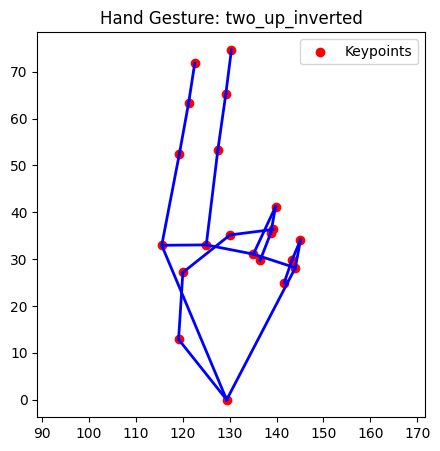

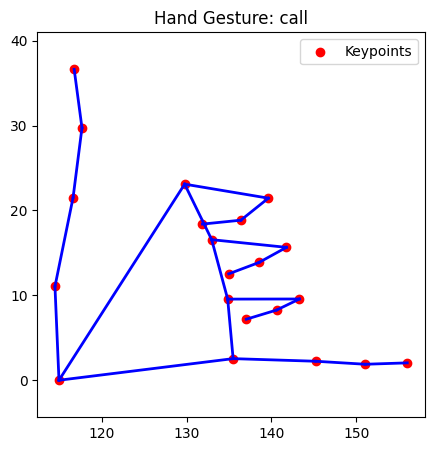

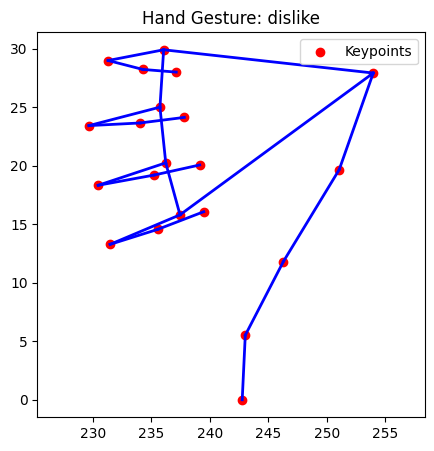

In [27]:
# Plotting the hand gestures
# Plotting a few samples of each gesture


label_like_df = data[data['label'] == 'like']
plot_hand_gesture(label_like_df, 2)
label_fist_df = data[data['label'] == 'fist']
plot_hand_gesture(label_fist_df, 34)
label_four_df = data[data['label'] == 'four']
plot_hand_gesture(label_four_df, 14)
label_mute_df = data[data['label'] == 'mute']
plot_hand_gesture(label_mute_df, 1)
label_ok_df = data[data['label'] == 'ok']
plot_hand_gesture(label_ok_df, 34)
label_one_df = data[data['label'] == 'one']
plot_hand_gesture(label_one_df, 6)
label_palm_df = data[data['label'] == 'palm']
plot_hand_gesture(label_palm_df, 20)
label_peace_df = data[data['label'] == 'peace']
plot_hand_gesture(label_peace_df, 7)
label_peace_inverted_df = data[data['label'] == 'peace_inverted']
plot_hand_gesture(label_peace_inverted_df, 61)
label_rock_df = data[data['label'] == 'rock']
plot_hand_gesture(label_rock_df, 3)
label_stop_df = data[data['label'] == 'stop']
plot_hand_gesture(label_stop_df, 4)
label_stop_inverted_df = data[data['label'] == 'stop_inverted']
plot_hand_gesture(label_stop_inverted_df, 10)
label_three_df = data[data['label'] == 'three']
plot_hand_gesture(label_three_df, 10)
label_three2_df = data[data['label'] == 'three2']
plot_hand_gesture(label_three2_df, 10)
label_two_up_df = data[data['label'] == 'two_up']
plot_hand_gesture(label_two_up_df, 10)
label_two_up_inverted_df = data[data['label'] == 'two_up_inverted']
plot_hand_gesture(label_two_up_inverted_df, 45)
label_call_df = data[data['label'] == 'call']
plot_hand_gesture(label_call_df, 3)
label_dislike_df = data[data['label'] == 'dislike']
plot_hand_gesture(label_dislike_df, 15)